# Introduction

In this notebook, we've pulled the images from the Kaggle Histopathologic Cancer Detection competition - we're creating an algorithm to identify metastatic cancer in small image patches taken from digital pathology scans. 

Start with some basic checks to make sure our GPU is up and running

In [58]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
from tqdm import tqdm_notebook

In [2]:
torch.cuda.device_count(), torch.cuda.get_device_name(0), torch.version.cuda

(1, 'GeForce GTX 1080 Ti', '9.0.176')

# Looking through our data so far

Look through our training csv. Notice that the id's are lacking the '.tif': without it, the ImageDataBunch.from_df() won't know where to get the image files from. 

In [3]:
train_labels = pd.read_csv('train_labels.csv', engine='python')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
tfms = get_transforms()
data = ImageDataBunch.from_df('', train_labels, 
                              folder='train', test='test', ds_tfms = tfms, 
                              size=128, suffix='.tif')

More checks. Constantly checking what we got helps us avoid bugs 

In [5]:
data.classes

[0, 1]

# Create the model

The create_cnn() helps us create a convolutional neural network based on the data bunch and architecture we requested. ResNet50 is an architecture that leverages on "residuals". Prior to the widespread use of residuals, deep neural networks didn't work very well - it seemed past a certain depth, more layers didn't help. In some instances, they seemed to hurt. Residuals involve adding "skip connections" - essentially, allowing the network to skip a layer if that helped it perform better. You can sort of think of this as the network learning how deep certain connections should go. 

In [147]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

Part of getting these neural networks to work involve hyperparameter tuning - one of the most important hyperparameters is the learning rate. You can intuitively think of this as the "step size" the model is making as its trying to improve itself. Too high a learning rate and the model never converges and never learns. Too low and the model learns rather slowly. 

Calling lr_find() in the learn object tells our model to try a range of different learning rates and learn.recorded.plot() plots how the loss function varies with the learning rates. The objective here is to determine the best learning rate to start training at.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03


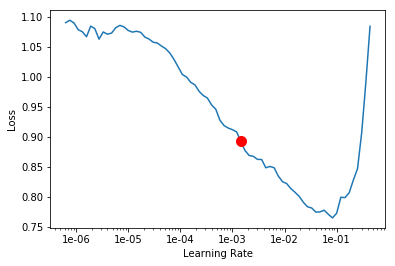

In [148]:
learn.lr_find()
learn.recorder.plot()

In [150]:
learn.fit_one_cycle(6, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.226886,0.184452,0.930144
2,0.175033,0.140728,0.948642
3,0.145177,0.132717,0.952005
4,0.138473,0.112672,0.960027
5,0.128821,0.101969,0.964595
6,0.113678,0.100623,0.965504


In [151]:
learn.save('phase_1')

Let's take a look at how our unfrozen model did by taking a look at images that had the highest "loss" (ie. the model was most wrong with) and by plotting a confusion matrix. 

1. Checking the highest losses will help us asses where the model is making the most mistakes.
1. A confusion matrix is a matrix that shows how many times the model misclassified each class. 

In [154]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(losses)

True

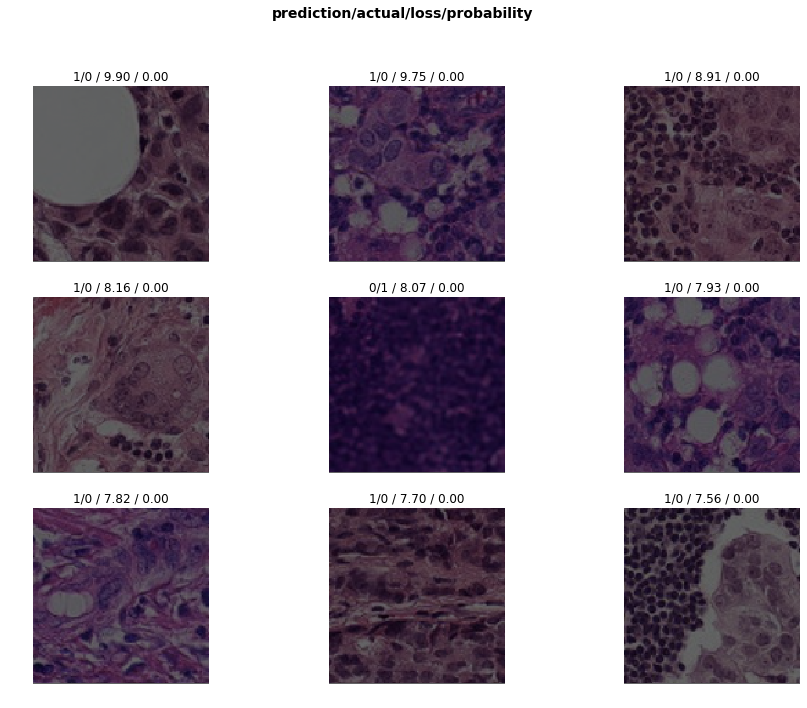

In [155]:
interp.plot_top_losses(9, figsize=(15,11))

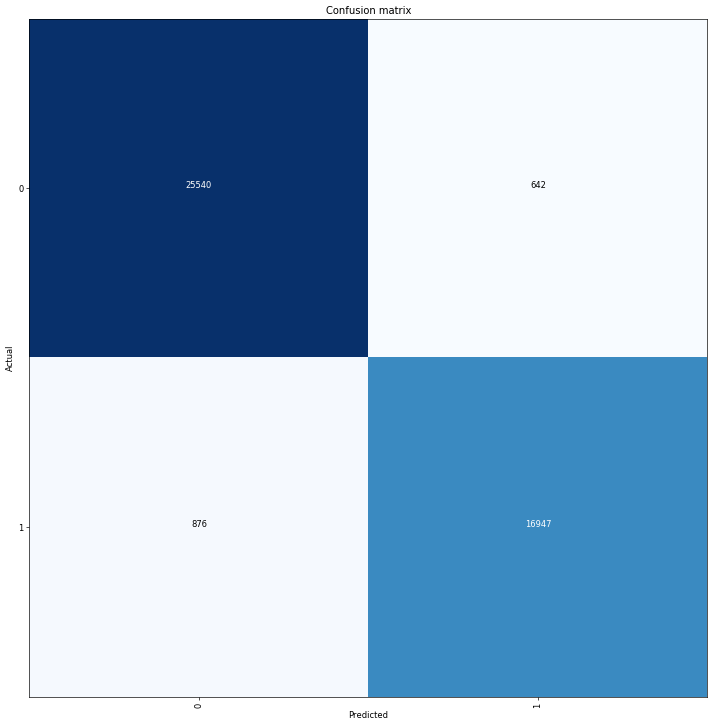

In [156]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# The Second Phase

Now that we have trained the head first, we can unfreeze. By not unfreezing the model at the beginning, we avoid spoiling our weights further down. In my experience, this doesn't always matter - intuitively, I suppose it would depend on how different the images we're training on differ from the images the pretrained modelw as trained on. 

In [157]:
learn.load('phase_1')

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,1,0,0,0
Path: .;

Valid: LabelList (44005 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,1,1,0
Path: .;

Test: LabelList (57458 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=

In [158]:
learn.unfreeze()

The unfrozen model is different from before so we must unfreeze it to check the optimal learning rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


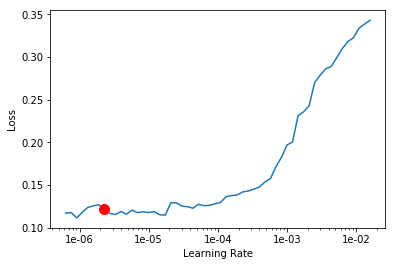

In [159]:
learn.lr_find()
learn.recorder.plot()

In [160]:
learn.fit_one_cycle(24, max_lr=slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy
1,0.122884,0.099035,0.966095
2,0.124962,0.099715,0.964981
3,0.109844,0.093592,0.967754
4,0.116512,0.092125,0.968072
5,0.095458,0.089657,0.968776
6,0.091872,0.087035,0.969890
7,0.094390,0.080086,0.972867
8,0.080290,0.079112,0.972980
9,0.079355,0.078099,0.973867
10,0.076369,0.077037,0.973662


In [ ]:
learn.fit_one_cycle(12, max_lr=slice(1e-6, 5e-5))

In [161]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(losses)

True

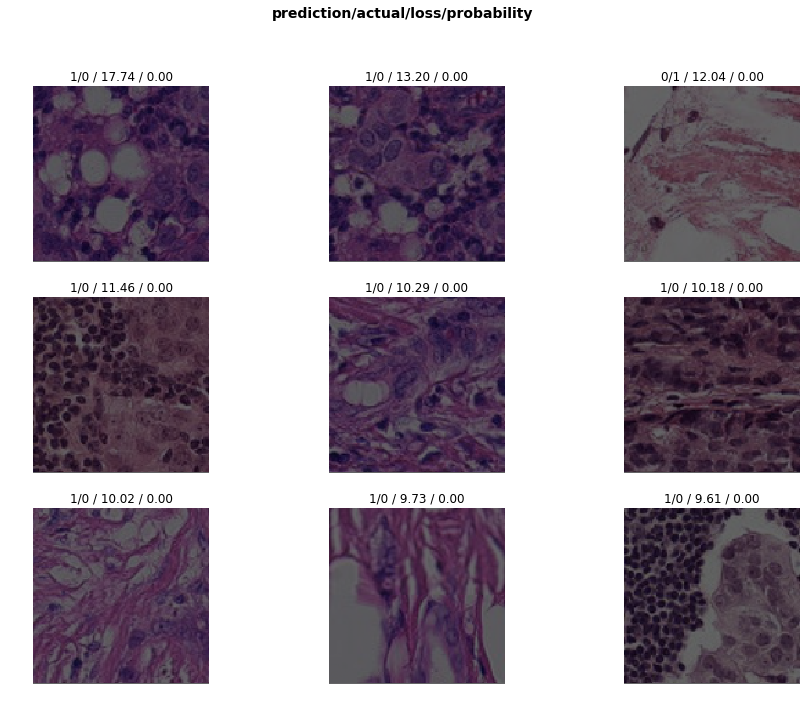

In [162]:
interp.plot_top_losses(9, figsize=(15,11))

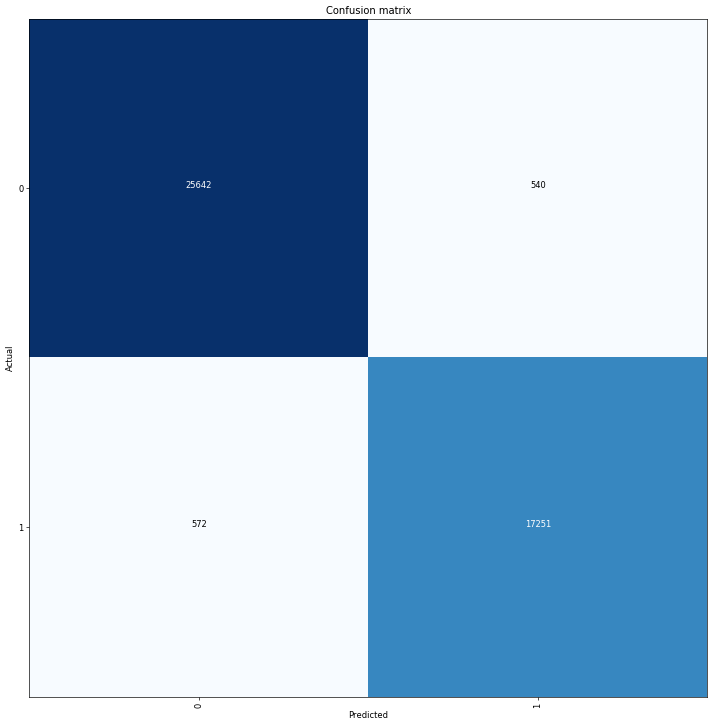

In [163]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


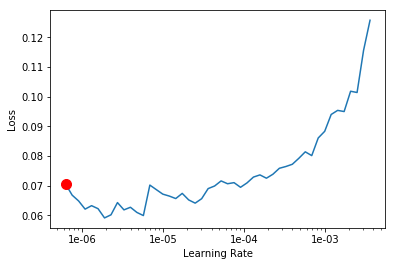

In [172]:
learn.lr_find()
learn.recorder.plot()

In [173]:
learn.fit_one_cycle(12, max_lr=slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy
1,0.074492,0.076701,0.974389
2,0.083370,0.076773,0.974230
3,0.082371,0.077198,0.974071
4,0.081829,0.077295,0.974298
5,0.072280,0.077036,0.974912
6,0.075357,0.076195,0.975094
7,0.057613,0.081127,0.973049
8,0.056965,0.078712,0.975094
9,0.057713,0.072933,0.977275
10,0.051786,0.073220,0.977389


In [174]:
learn.save('phase_2')

In [175]:
learn.export()

Now that you've seen a ResNet50 implementation, we can repeat the process with different ResNet architectures, some deeper, some shallower.

# ResNet18

In [49]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03


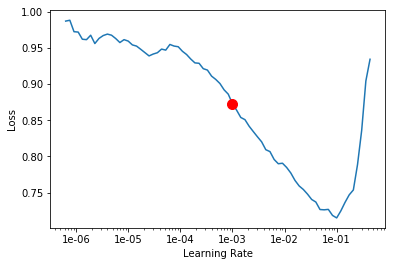

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(6, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.243346,0.230793,0.908533
2,0.245143,0.554531,0.791069
3,0.218328,0.187024,0.929235
4,0.205852,0.155651,0.942847
5,0.184933,0.172351,0.940802
6,0.168750,0.153512,0.945506


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


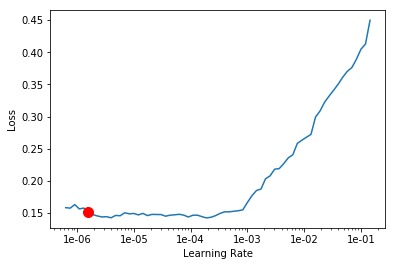

In [54]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(24, max_lr= slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.176969,0.147972,0.948506
2,0.165084,0.145240,0.948688
3,0.167170,0.145674,0.948779
4,0.168168,0.144046,0.949528
5,0.170781,0.137273,0.950278
6,0.154819,0.132119,0.952778
7,0.164416,0.142675,0.950324
8,0.145762,0.146217,0.954051
9,0.146487,0.130032,0.955232
10,0.149156,0.123270,0.956823


In [56]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses)

True

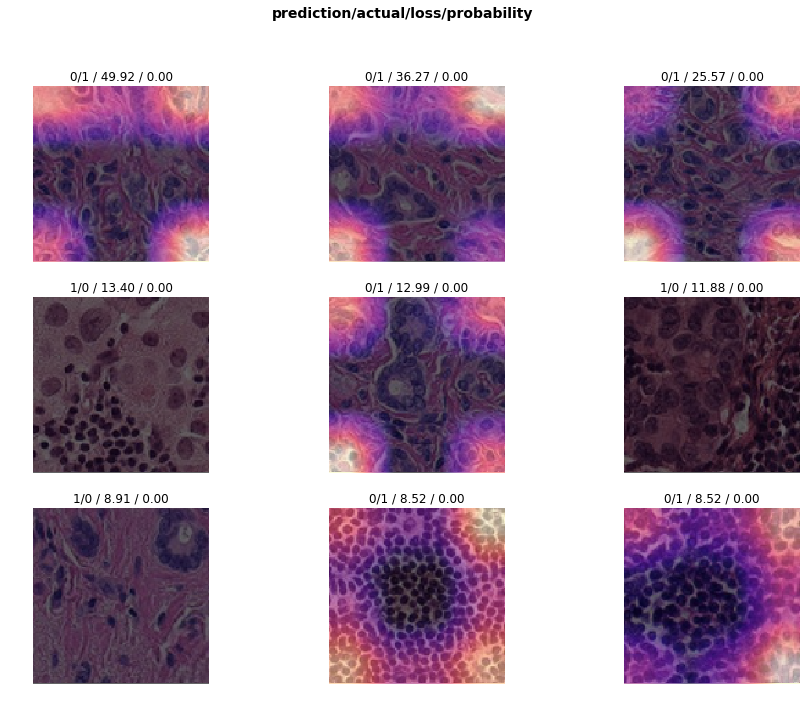

In [57]:
interp.plot_top_losses(9, figsize=(15,11))

# ResNet34

In [27]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04


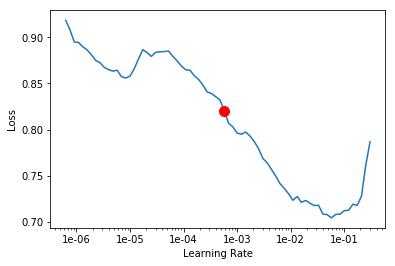

In [28]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(6, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.289362,0.740707,0.748529
2,0.249904,0.574070,0.786638
3,0.220573,5.352015,0.759186
4,0.185398,0.282086,0.882991
5,0.168882,0.138048,0.948824
6,0.145217,0.116218,0.958777


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


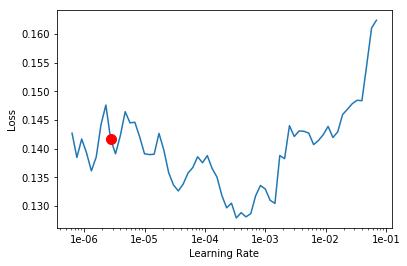

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(24, max_lr= 1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.140183,0.115180,0.959027
2,0.139304,0.116086,0.959118
3,0.130355,0.114723,0.959346
4,0.133249,0.115377,0.959027
5,0.145524,0.114756,0.959300
6,0.146829,0.115035,0.959027
7,0.131199,0.112618,0.959596
8,0.133232,0.112542,0.959914
9,0.136472,0.112083,0.960254
10,0.130801,0.112803,0.959755


In [35]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses)

True

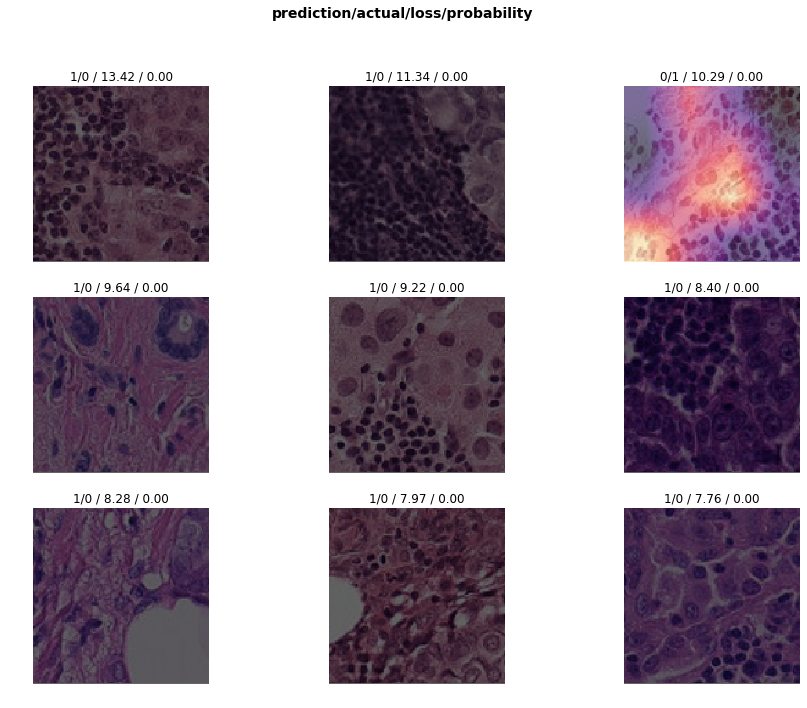

In [36]:
interp.plot_top_losses(9, figsize=(15,11))

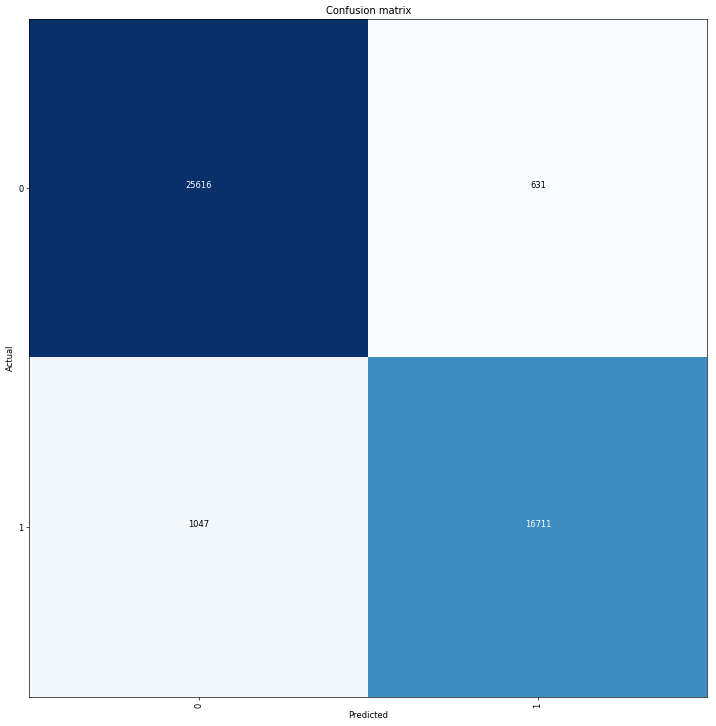

In [37]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# ResNet101

In [49]:
learn = create_cnn(data, models.resnet101, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04


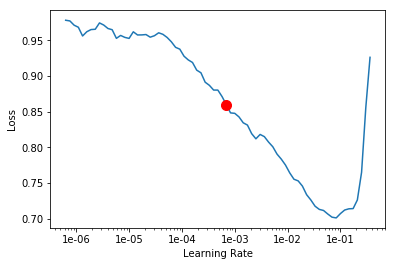

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(6, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.241998,0.294587,0.881241
2,0.215486,0.195552,0.925372
3,0.201897,0.158352,0.940529
4,0.166131,0.150156,0.944029
5,0.129348,0.117648,0.960436
6,0.125873,0.111181,0.962300


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


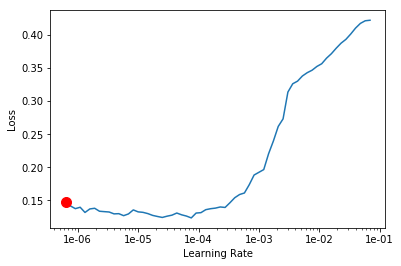

In [52]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(24, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.135306,0.110687,0.962482
2,0.126547,0.107578,0.963231
3,0.128179,0.127050,0.962436
4,0.111975,0.103949,0.963890
5,0.131944,0.105113,0.963277
6,0.131673,0.100968,0.965413
7,0.115239,0.097141,0.966458
8,0.120894,0.096221,0.966754
9,0.100913,0.099750,0.965663
10,0.105128,0.095897,0.966367


In [54]:
learn.save('phase_2')
learn.export()

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses)

True

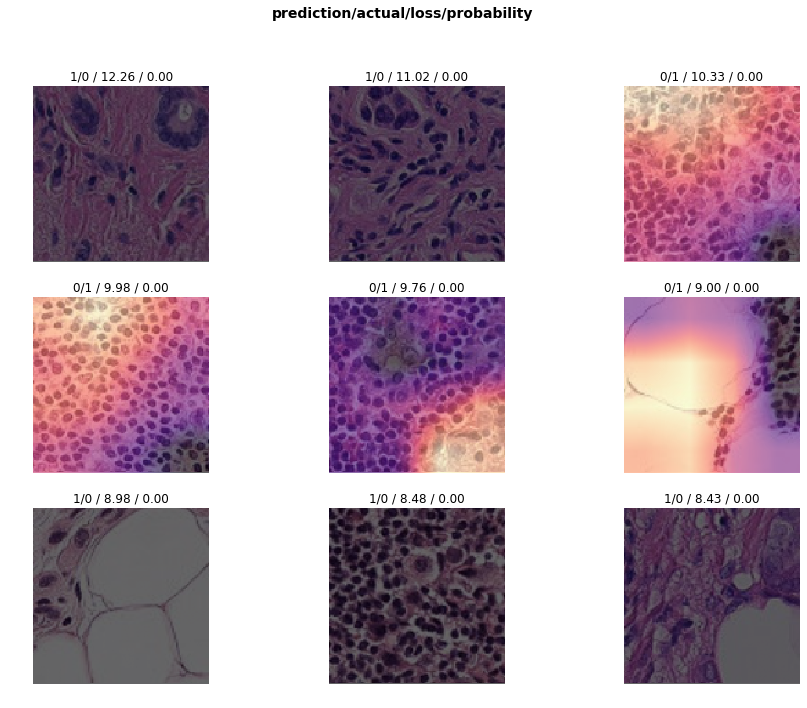

In [56]:
interp.plot_top_losses(9, figsize=(15,11))

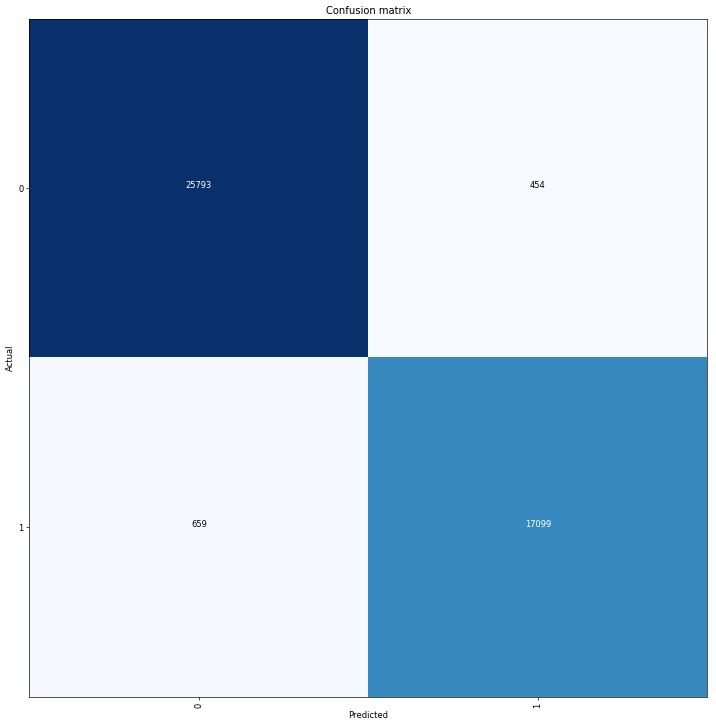

In [58]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# ResNet 152

In [5]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


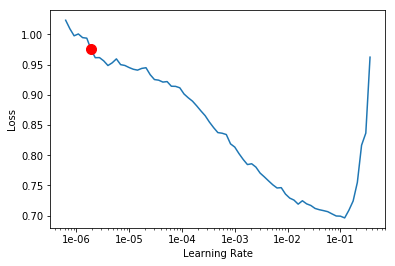

In [6]:
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,accuracy
1,0.255442,0.212210,0.916191
2,0.206490,0.158108,0.943166
3,0.166285,0.131481,0.953551
4,0.148354,0.115456,0.958709
5,0.146640,0.106071,0.962550
6,0.133908,0.102546,0.964231
7,0.120627,0.098237,0.966299
8,0.115844,0.094799,0.967299
9,0.109852,0.092661,0.968322


In [8]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


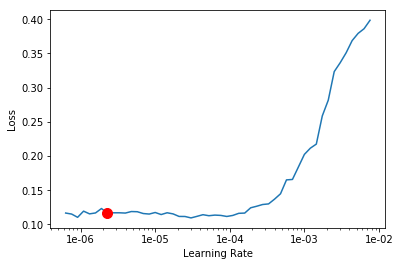

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(36, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.113593,0.094428,0.968049
2,0.113710,0.094849,0.967345
3,0.104463,0.092590,0.968140
4,0.100573,0.090576,0.969435
5,0.103986,0.087497,0.970344
6,0.103274,0.087608,0.970231
7,0.094288,0.086131,0.970708
8,0.101258,0.088571,0.969390
9,0.098081,0.083103,0.972140
10,0.092957,0.083219,0.972094


In [40]:
learn.fit_one_cycle(9, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.027248,0.078176,0.979275
2,0.041473,0.084252,0.978684
3,0.045351,0.080960,0.978457
4,0.044450,0.084237,0.977184
5,0.037044,0.083055,0.978207
6,0.025993,0.081323,0.979321
7,0.024882,0.081616,0.980570
8,0.019740,0.078303,0.980661
9,0.019951,0.077366,0.981570


In [ ]:
learn.fit_one_cycle(9, max_lr=slice(1e-6, 1e-4))

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses)

True

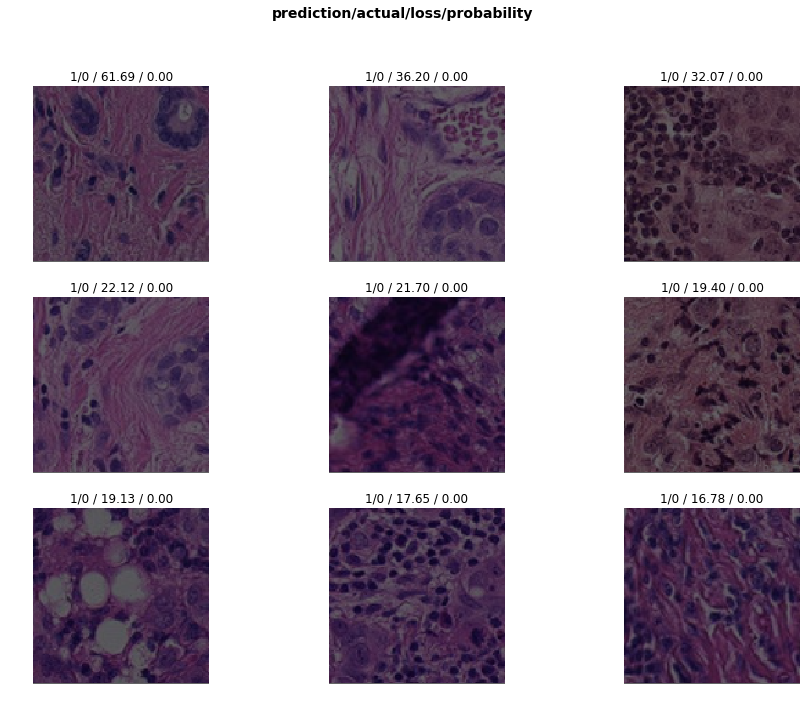

In [42]:
interp.plot_top_losses(9, figsize=(15,11))

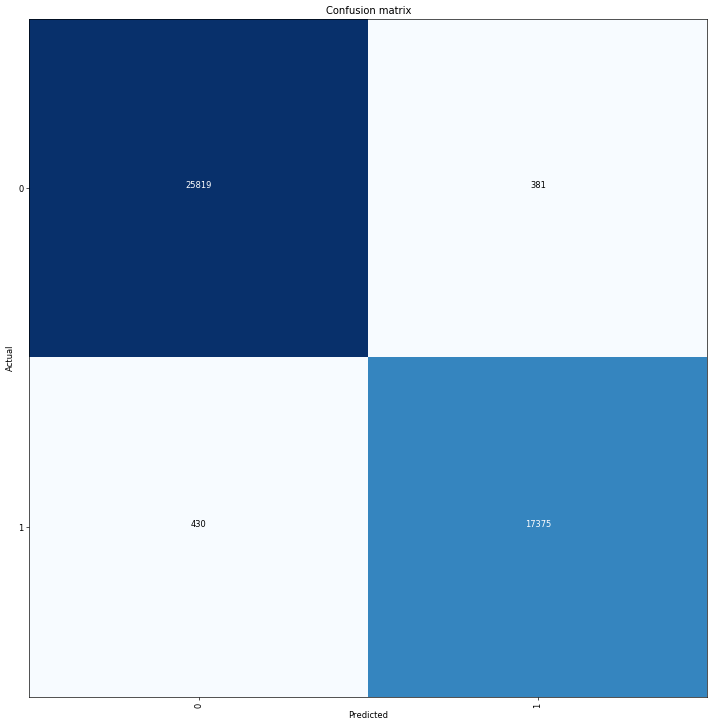

In [43]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [54]:
learn.export()
learn.save('resnet152')

# Test Time

In [70]:
learn.load('resnet152')

n_aug = 12
preds_n_avg = np.zeros((len(learn.data.test_ds.items),2))

for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learn.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
    
preds_n_avg = preds_n_avg / n_aug

In [71]:
tumor_preds = preds_n_avg[:, 1] #get only the predicted probabilities (ie. 70% chance no tumour)
class_preds = np.argmax(preds_n_avg, axis=1) #get the index to predict the class (ie. predict 0, no tumour)

classes = ['Negative','Tumor']
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
print('Tumor probability: ' + str(tumor_preds[0]))
print('Class prediction: ' + classes[class_preds[0]])

Negative and Tumor Probabilities: [7.898484e-05 9.999210e-01]
Tumor probability: 0.9999209642410278
Class prediction: Tumor


Check the prediction we get back from the model. 
Note a few things:
1. That we need to convert the model's confidence of each class into actual predictions. 
1. That the prediction we get back is a pytorch tensor NOT a numpy array

After this, we prepare the submission file of the test data.

In [72]:
preds_n_avg

array([[7.898484e-05, 9.999210e-01],
       [1.000000e+00, 1.342757e-09],
       [1.000000e+00, 1.904054e-08],
       [1.000000e+00, 2.421510e-08],
       ...,
       [9.946349e-01, 5.365202e-03],
       [9.999918e-01, 8.283216e-06],
       [9.999999e-01, 1.458498e-07],
       [9.999908e-01, 9.152950e-06]])

In [73]:
preds_n_avg = np.argmax(preds_n_avg, axis=1) #get the class for each row

SAMPLE_SUB = 'sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id) #get the for the test data

In [98]:
#create a list of predictions that are not sorted [pred3, pred1, pred3...etc] 
pred_list = [p for p in tumor_preds] 

#tie each prediction to the test id inside the model {id: pred}
pred_dic = dict((str(key), value) for (key, value) in zip(learn.data.test_ds.items, pred_list))

#get the prediction for each id in the test set [pred1, pred2, pred3...etc]
pred_list_cor = [pred_dic['test/' + sampId + '.tif'] for sampId in sample_list] 

In [100]:
#save it all out
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})
df_sub.to_csv('submission.csv', header=True, index=False)